In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



In [ ]:



df = pd.read_csv('https://raw.githubusercontent.com/huy164/datasets/master/walmart_stock_price.csv', parse_dates=['Date'], index_col='Date')


train_size = int(len(df) * 0.7)
test_size = int(len(df) * 0.2)
valid_size = len(df) - train_size - test_size

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:train_size+test_size]
valid_data = df.iloc[train_size+test_size:]



scaler = StandardScaler()
train_data_norm = scaler.fit_transform(train_data)
test_data_norm = scaler.transform(test_data)
valid_data_norm = scaler.transform(valid_data)



inputs = Input(shape=(train_data_norm.shape[1], 1))
conv1 = Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu')(inputs)
conv2 = Conv1D(filters=64, kernel_size=3, padding='causal', dilation_rate=2, activation='relu')(conv1)
conv3 = Conv1D(filters=128, kernel_size=3, padding='causal', dilation_rate=4, activation='relu')(conv2)
gap = GlobalAveragePooling1D()(conv3)
outputs = Dense(1)(gap)
model = Model(inputs=inputs, outputs=outputs)



model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')



history = model.fit(train_data_norm.reshape(-1, train_data_norm.shape[1], 1), train_data_norm[:, -1], 
                    epochs=50, batch_size=32, verbose=0)




In [ ]:
test_pred = scaler.inverse_transform(model.predict(test_data_norm.reshape(-1, test_data_norm.shape[1], 1)))
test_rmse = np.sqrt(mean_squared_error(test_data.iloc[:, -1], test_pred))
print('Test RMSE:', test_rmse)

test_mape = np.mean(np.abs((test_data.iloc[:, -1].values - test_pred) / test_data.iloc[:, -1].values)) * 100
print('Test MAPE:', test_mape)

test_mae = mean_absolute_error(test_data.iloc[:, -1], test_pred)
print('Test MAE:', test_mae)

79/79 [==============================] - 0s 2ms/step
Test RMSE: 0.49384571347396633
Test MAPE: 21.00388866035659
Test MAE: 0.37667784489310185


In [ ]:
valid_pred = scaler.inverse_transform(model.predict(valid_data_norm.reshape(-1, valid_data_norm.shape[1], 1)))
valid_rmse = np.sqrt(mean_squared_error(valid_data.iloc[:, -1], valid_pred))
print('Valid RMSE:', test_rmse)

valid_mape = np.mean(np.abs((valid_data.iloc[:, -1].values - valid_pred) / valid_data.iloc[:, -1].values)) * 100
print('Valid MAPE:', test_mape)

valid_mae = mean_absolute_error(valid_data.iloc[:, -1], valid_pred)
print('Valid MAE:', test_mae)

40/40 [==============================] - 0s 2ms/step
Valid RMSE: 0.49384571347396633
Valid MAPE: 21.00388866035659
Valid MAE: 0.37667784489310185


40/40 [==============================] - 0s 2ms/step


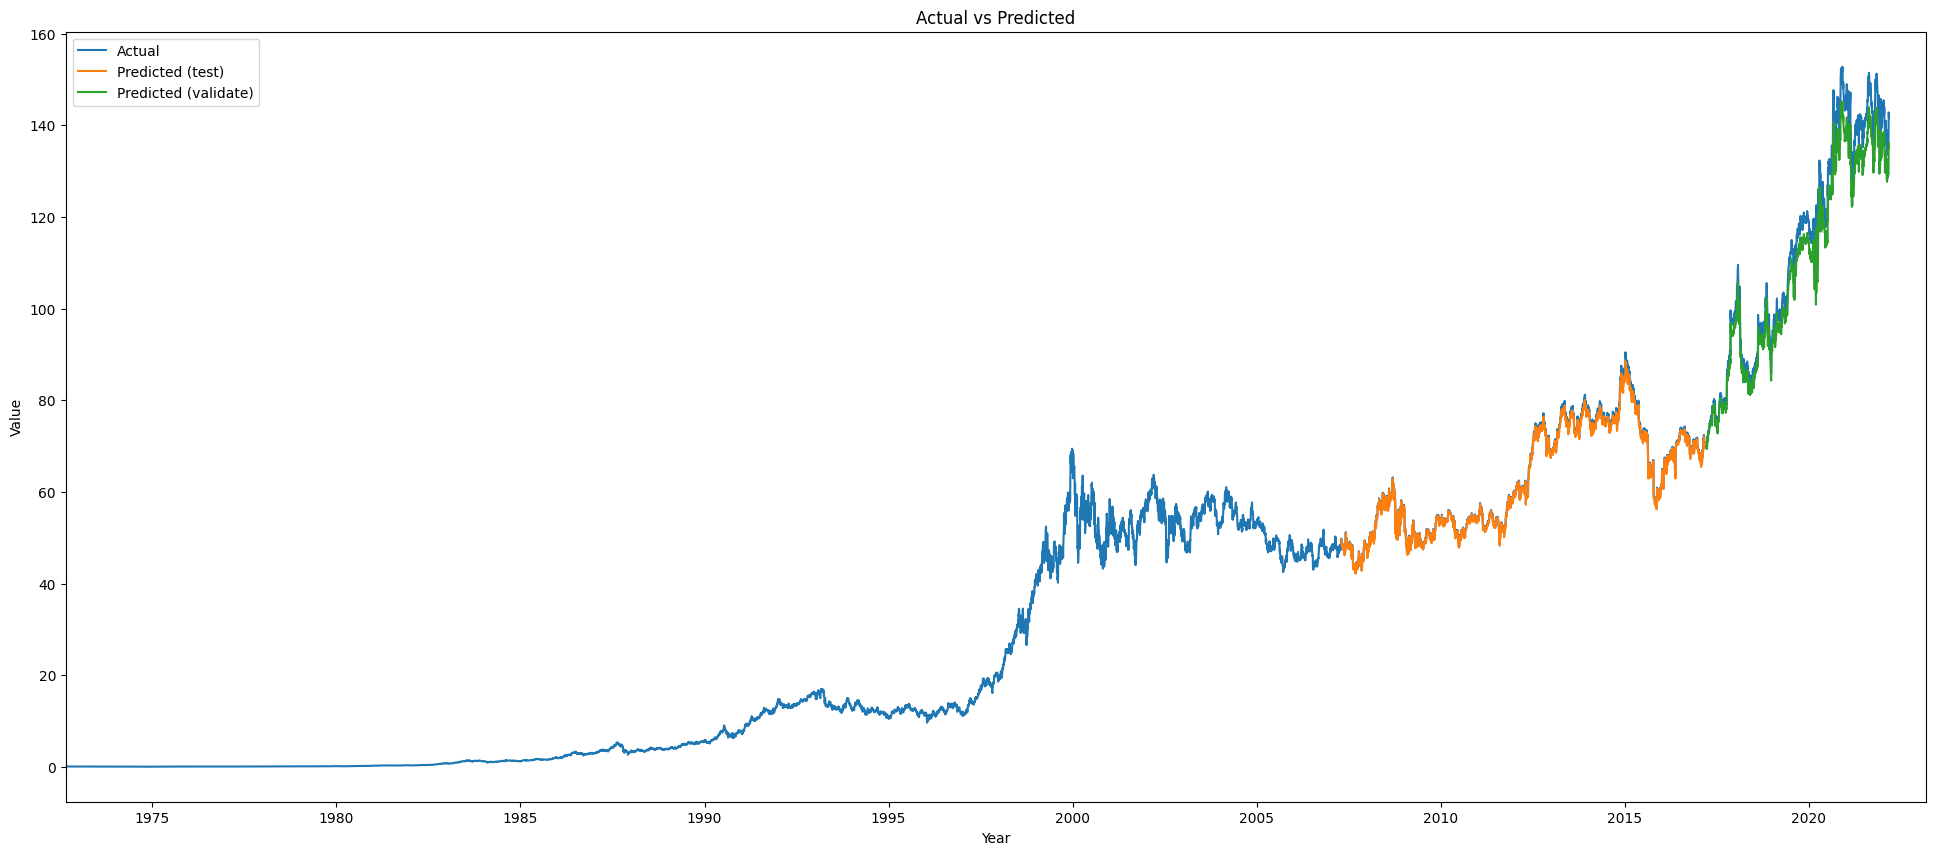

In [ ]:

df.index = pd.to_datetime(df.index)


test_pred = scaler.inverse_transform(model.predict(test_data_norm.reshape(-1, test_data_norm.shape[1], 1)))
valid_pred = scaler.inverse_transform(model.predict(valid_data_norm.reshape(-1, valid_data_norm.shape[1], 1)))



fig, ax = plt.subplots(figsize=(24, 10))

plt.plot(df.index, df.iloc[:, -1].values, label='Actual')
plt.plot(test_data.index, test_pred[:, -1], label='Predicted (test)')
plt.plot(valid_data.index, valid_pred[:, -1], label='Predicted (validate)')
plt.title('Actual vs Predicted')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()

plt.xlim(df.index[0], df.index[-1] + pd.DateOffset(years=1))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))
plt.gca().xaxis.set_major_formatter(mdates.AutoDateFormatter(mdates.YearLocator(base=5)))

plt.show()


1/1 [==============================] - 0s 58ms/step


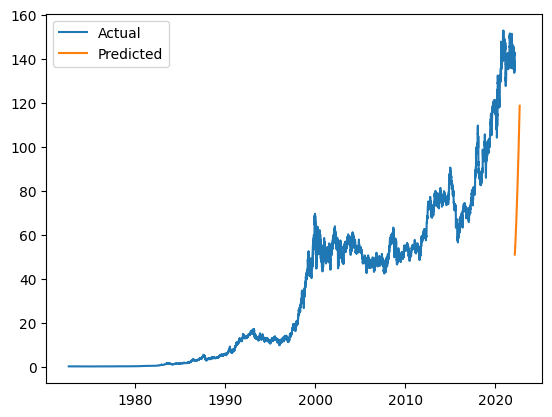

In [ ]:
n_steps = 30
n_features = 1

# make predictions for the next 100 days
next_100_days_norm = []
pred_day = np.zeros((1, n_steps, n_features))
pred_day[:, :, 0] = train_data_norm[-n_steps:, :].T  # Transpose train_data_norm
for i in range(200):
    pred = model.predict(pred_day)
    next_100_days_norm.append(pred)
    # Update pred_day with the latest prediction
    pred_day[:, :-1, :] = pred_day[:, 1:, :]
    pred_day[:, -1, :] = pred

# convert predictions back to actual values
next_100_days = scaler.inverse_transform(np.array(next_100_days_norm).reshape(-1, n_features))
# create a datetime index for the next 100 days
last_date = df.index[-1]
next_100_days_idx = pd.date_range(start=last_date, periods=200, freq='D')

# plot the predictions
plt.plot(df.index, df.iloc[:, -1].values, label='Actual')
plt.plot(next_100_days_idx, next_100_days, label='Predicted')
plt.legend()
plt.show()



1/1 [==============================] - 0s 22ms/step


NameError: ignored

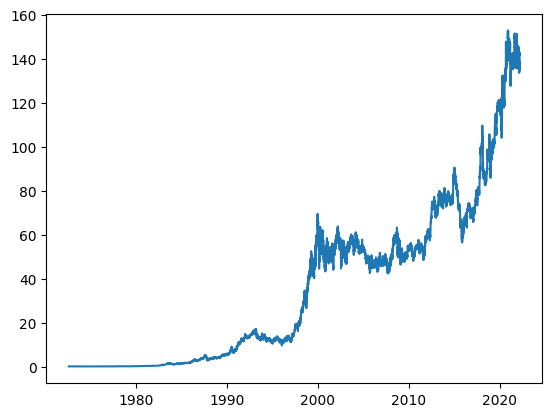

In [ ]:
# Define the date for which to make the prediction
prediction_date = '2023-05-10'

# Get the data for the prediction date
prediction_data = df[df['date']==prediction_date].iloc[:,1:].values

# Normalize the prediction data
prediction_data_norm = scaler.transform(prediction_data.reshape(-1, prediction_data.shape[1]))

# Reshape the prediction data to match the input shape of the model
prediction_data_norm = prediction_data_norm.reshape(1, prediction_data_norm.shape[0], prediction_data_norm.shape[1])

# Predict the closing price for the prediction date
predicted_close = scaler.inverse_transform(model.predict(prediction_data_norm))[0,-1]

print("Predicted closing price for", prediction_date, "is:", predicted_close)

# Plot the actual and predicted closing prices for the prediction date and the previous 10 days
prev_days = 10
plot_data = df[df['date']>=(pd.to_datetime(prediction_date)-pd.Timedelta(days=prev_days))]
plot_dates = plot_data['date']
plot_actual = plot_data['close']
plot_predicted = np.empty_like(plot_actual)
plot_predicted.fill(np.nan)
plot_predicted[-1] = predicted_close

plt.figure(figsize=(12,6))
plt.plot(plot_dates, plot_actual, label='Actual')
plt.plot(plot_dates, plot_predicted, label='Predicted')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices for ' + prediction_date + ' and Previous ' + str(prev_days) + ' Days')
plt.legend()
plt.show()








ValueError: ignored

In [ ]:
train_data_norm.shape[-1]

1

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data into a pandas DataFrame
df = pd.read_csv('https://raw.githubusercontent.com/huy164/datasets/master/WMT.csv')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['Open', 'High', 'Low', 'Adj Close', 'Volume']], 
                                                    df['Close'], test_size=0.3, random_state=42)


from sklearn.linear_model import LinearRegression

# Train the LR model
lr = LinearRegression()
lr.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the testing data
y_pred = lr.predict(X_test)

# Compute the MSE and R^2 scores
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("R^2: ", r2)


MSE:  0.08167985293451316
R^2:  0.9999416662669528


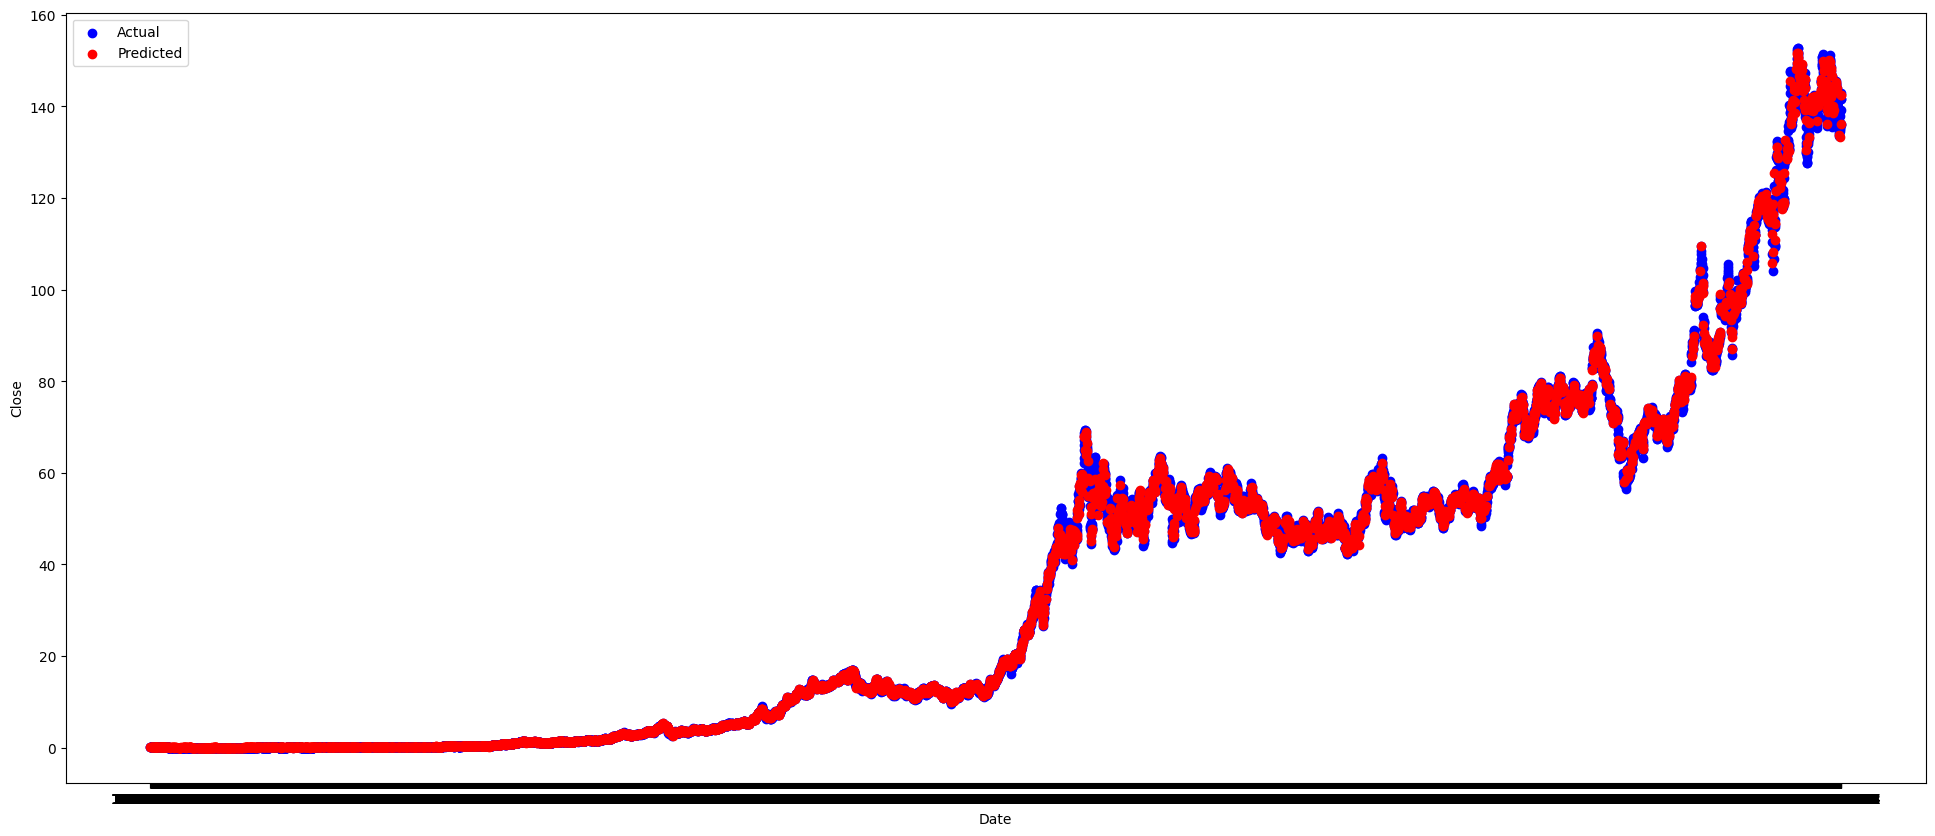

In [ ]:
import matplotlib.pyplot as plt

y_pred = lr.predict(X_test)

fig, ax = plt.subplots(figsize=(24, 10))

plt.scatter(df['Date'], df['Close'], color='blue', label='Actual')
plt.scatter(X_test.index, y_pred, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()
